In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from __future__ import print_function
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import os
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [27]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [28]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=7, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.Resnet18 = resnet18()
        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(10,50)
        self.fc2 = nn.Linear(50,7)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 512),
            nn.Sigmoid()    
        )

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = F.dropout(xs)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
       
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
   
        return x

    def forward(self,input):
        out = self.stn(input)
        out = self.Resnet18(out)
        # out = F.dropout(out)
        # out = F.relu(self.fc1(out))
        # out = self.fc2(out)
        
        return out

In [30]:
class Plain_Dataset(Dataset):
    def __init__(self,csv_file,img_dir,datatype,transform):
        '''
        Pytorch Dataset class
        params:-
                 csv_file : the path of the csv file    (train, validation, test)
                 img_dir  : the directory of the images (train, validation, test)
                 datatype : string for searching along the image_dir (train, val, test)
                 transform: pytorch transformation over the data
        return :-
                 image, labels
        '''
        self.csv_file = pd.read_csv(csv_file)
        self.lables = self.csv_file['emotion']
        self.img_dir = img_dir
        self.transform = transform
        self.datatype = datatype

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = Image.open(self.img_dir+self.datatype+str(idx)+'.jpg')
        lables = np.array(self.lables[idx])
        lables = torch.from_numpy(lables).long()

        if self.transform :
            img = self.transform(img)
        return img,lables

#Helper function
def eval_data_dataloader(csv_file,img_dir,datatype,sample_number,transform= None):
    '''
    Helper function used to evaluate the Dataset class
    params:-
            csv_file : the path of the csv file    (train, validation, test)
            img_dir  : the directory of the images (train, validation, test)
            datatype : string for searching along the image_dir (train, val, test)
            sample_number : any number from the data to be shown
    '''
    if transform is None :
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
    dataset = Plain_Dataset(csv_file=csv_file,img_dir = img_dir,datatype = datatype,transform = transform)

    label = dataset.__getitem__(sample_number)[1]
    print(label)
    imgg = dataset.__getitem__(sample_number)[0]
    imgnumpy = imgg.numpy()
    imgt = imgnumpy.squeeze()
    plt.imshow(imgt)
    plt.show()

# CenterLoss

In [31]:

import torch
import torch.nn as nn

class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

# Train

train without center loss 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 42, 42]             400
         MaxPool2d-2            [-1, 8, 21, 21]               0
              ReLU-3            [-1, 8, 21, 21]               0
            Conv2d-4           [-1, 10, 17, 17]           2,010
         MaxPool2d-5             [-1, 10, 8, 8]               0
              ReLU-6             [-1, 10, 8, 8]               0
            Linear-7                   [-1, 32]          20,512
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10           [-1, 64, 24, 24]           3,136
      BatchNorm2d-11           [-1, 64, 24, 24]             128
             ReLU-12           [-1, 64, 24, 24]               0
        MaxPool2d-13           [-1, 64, 12, 12]               0
           Conv2d-14           [-1, 64,

100%|██████████| 75/75 [00:03<00:00, 22.88it/s]


Epoch : 1 - loss : 1.4291 - acc: 0.4717 - val_loss : 1.1068 - val_acc: 0.5724



100%|██████████| 75/75 [00:01<00:00, 47.84it/s]


Epoch : 2 - loss : 0.9822 - acc: 0.6417 - val_loss : 1.1919 - val_acc: 0.6104



100%|██████████| 75/75 [00:01<00:00, 47.63it/s]


Epoch : 3 - loss : 0.7412 - acc: 0.7417 - val_loss : 0.5790 - val_acc: 0.7969



100%|██████████| 75/75 [00:01<00:00, 47.16it/s]


Epoch : 4 - loss : 0.4668 - acc: 0.8233 - val_loss : 0.4839 - val_acc: 0.8333



100%|██████████| 75/75 [00:01<00:00, 47.20it/s]


Epoch : 5 - loss : 0.3436 - acc: 0.8850 - val_loss : 0.5932 - val_acc: 0.8094



100%|██████████| 75/75 [00:01<00:00, 46.39it/s]


Epoch : 6 - loss : 0.3055 - acc: 0.9000 - val_loss : 0.4225 - val_acc: 0.8604



100%|██████████| 75/75 [00:01<00:00, 43.87it/s]


Epoch : 7 - loss : 0.2907 - acc: 0.8983 - val_loss : 0.8173 - val_acc: 0.7510



100%|██████████| 75/75 [00:01<00:00, 46.30it/s]


Epoch : 8 - loss : 0.2881 - acc: 0.9117 - val_loss : 0.3837 - val_acc: 0.8672



100%|██████████| 75/75 [00:01<00:00, 46.72it/s]


Epoch : 9 - loss : 0.2177 - acc: 0.9217 - val_loss : 0.2958 - val_acc: 0.9089



100%|██████████| 75/75 [00:01<00:00, 46.86it/s]


Epoch : 10 - loss : 0.1388 - acc: 0.9583 - val_loss : 0.2118 - val_acc: 0.9349



100%|██████████| 75/75 [00:01<00:00, 46.26it/s]


Epoch : 11 - loss : 0.1128 - acc: 0.9633 - val_loss : 0.2331 - val_acc: 0.9323



100%|██████████| 75/75 [00:01<00:00, 45.88it/s]


Epoch : 12 - loss : 0.0578 - acc: 0.9817 - val_loss : 0.5684 - val_acc: 0.8656



100%|██████████| 75/75 [00:01<00:00, 46.58it/s]


Epoch : 13 - loss : 0.1937 - acc: 0.9400 - val_loss : 0.1890 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 46.62it/s]


Epoch : 14 - loss : 0.0796 - acc: 0.9817 - val_loss : 0.1162 - val_acc: 0.9620



100%|██████████| 75/75 [00:01<00:00, 47.14it/s]


Epoch : 15 - loss : 0.0121 - acc: 0.9983 - val_loss : 0.1237 - val_acc: 0.9583



100%|██████████| 75/75 [00:01<00:00, 47.86it/s]


Epoch : 16 - loss : 0.0359 - acc: 0.9883 - val_loss : 0.1810 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 47.84it/s]


Epoch : 17 - loss : 0.0435 - acc: 0.9900 - val_loss : 0.1266 - val_acc: 0.9583



100%|██████████| 75/75 [00:01<00:00, 47.44it/s]


Epoch : 18 - loss : 0.1175 - acc: 0.9733 - val_loss : 0.3444 - val_acc: 0.9271



100%|██████████| 75/75 [00:01<00:00, 47.42it/s]


Epoch : 19 - loss : 0.1130 - acc: 0.9750 - val_loss : 0.2352 - val_acc: 0.9297



100%|██████████| 75/75 [00:01<00:00, 47.66it/s]


Epoch : 20 - loss : 0.0736 - acc: 0.9817 - val_loss : 0.2075 - val_acc: 0.9271



100%|██████████| 75/75 [00:01<00:00, 46.74it/s]


Epoch : 21 - loss : 0.0574 - acc: 0.9800 - val_loss : 0.2809 - val_acc: 0.9255



100%|██████████| 75/75 [00:01<00:00, 46.68it/s]


Epoch : 22 - loss : 0.1855 - acc: 0.9450 - val_loss : 0.2935 - val_acc: 0.9167



100%|██████████| 75/75 [00:01<00:00, 46.17it/s]


Epoch : 23 - loss : 0.0671 - acc: 0.9800 - val_loss : 0.3527 - val_acc: 0.9193



100%|██████████| 75/75 [00:01<00:00, 47.46it/s]


Epoch : 24 - loss : 0.0356 - acc: 0.9917 - val_loss : 0.1940 - val_acc: 0.9505



100%|██████████| 75/75 [00:01<00:00, 45.76it/s]


Epoch : 25 - loss : 0.0244 - acc: 0.9950 - val_loss : 0.2505 - val_acc: 0.9323



100%|██████████| 75/75 [00:01<00:00, 47.58it/s]


Epoch : 26 - loss : 0.0179 - acc: 0.9933 - val_loss : 0.2754 - val_acc: 0.9271



100%|██████████| 75/75 [00:01<00:00, 46.62it/s]


Epoch : 27 - loss : 0.1652 - acc: 0.9583 - val_loss : 0.6724 - val_acc: 0.8266



100%|██████████| 75/75 [00:01<00:00, 47.52it/s]


Epoch : 28 - loss : 0.1782 - acc: 0.9467 - val_loss : 0.2285 - val_acc: 0.9333



100%|██████████| 75/75 [00:01<00:00, 47.51it/s]


Epoch : 29 - loss : 0.0340 - acc: 0.9917 - val_loss : 0.4598 - val_acc: 0.8646



100%|██████████| 75/75 [00:01<00:00, 47.93it/s]


Epoch : 30 - loss : 0.0512 - acc: 0.9917 - val_loss : 0.2147 - val_acc: 0.9427



100%|██████████| 75/75 [00:01<00:00, 47.87it/s]


Epoch : 31 - loss : 0.0347 - acc: 0.9883 - val_loss : 0.0509 - val_acc: 0.9870



100%|██████████| 75/75 [00:01<00:00, 48.01it/s]


Epoch : 32 - loss : 0.0065 - acc: 1.0000 - val_loss : 0.1306 - val_acc: 0.9557



100%|██████████| 75/75 [00:01<00:00, 47.72it/s]


Epoch : 33 - loss : 0.0022 - acc: 1.0000 - val_loss : 0.1107 - val_acc: 0.9646



100%|██████████| 75/75 [00:01<00:00, 47.29it/s]


Epoch : 34 - loss : 0.0012 - acc: 1.0000 - val_loss : 0.1118 - val_acc: 0.9609



100%|██████████| 75/75 [00:01<00:00, 48.41it/s]


Epoch : 35 - loss : 0.0010 - acc: 1.0000 - val_loss : 0.1054 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 46.13it/s]


Epoch : 36 - loss : 0.0008 - acc: 1.0000 - val_loss : 0.1151 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 48.92it/s]


Epoch : 37 - loss : 0.0006 - acc: 1.0000 - val_loss : 0.1482 - val_acc: 0.9583



100%|██████████| 75/75 [00:01<00:00, 46.38it/s]


Epoch : 38 - loss : 0.0007 - acc: 1.0000 - val_loss : 0.1394 - val_acc: 0.9583



100%|██████████| 75/75 [00:01<00:00, 45.52it/s]


Epoch : 39 - loss : 0.0004 - acc: 1.0000 - val_loss : 0.1403 - val_acc: 0.9635



100%|██████████| 75/75 [00:01<00:00, 46.26it/s]


Epoch : 40 - loss : 0.0005 - acc: 1.0000 - val_loss : 0.1551 - val_acc: 0.9635



100%|██████████| 75/75 [00:01<00:00, 48.65it/s]


Epoch : 41 - loss : 0.0006 - acc: 1.0000 - val_loss : 0.1447 - val_acc: 0.9583



100%|██████████| 75/75 [00:01<00:00, 48.86it/s]


Epoch : 42 - loss : 0.0006 - acc: 1.0000 - val_loss : 0.1469 - val_acc: 0.9635



100%|██████████| 75/75 [00:01<00:00, 48.49it/s]


Epoch : 43 - loss : 0.0005 - acc: 1.0000 - val_loss : 0.1573 - val_acc: 0.9635



100%|██████████| 75/75 [00:01<00:00, 48.19it/s]


Epoch : 44 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.1372 - val_acc: 0.9635



100%|██████████| 75/75 [00:01<00:00, 48.27it/s]


Epoch : 45 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.1241 - val_acc: 0.9714



100%|██████████| 75/75 [00:01<00:00, 48.96it/s]


Epoch : 46 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.1536 - val_acc: 0.9661



100%|██████████| 75/75 [00:01<00:00, 48.78it/s]


Epoch : 47 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.1358 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 49.02it/s]


Epoch : 48 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.1515 - val_acc: 0.9714



100%|██████████| 75/75 [00:01<00:00, 49.14it/s]


Epoch : 49 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.1695 - val_acc: 0.9568



100%|██████████| 75/75 [00:01<00:00, 49.18it/s]


Epoch : 50 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.0948 - val_acc: 0.9714



100%|██████████| 75/75 [00:01<00:00, 49.09it/s]


Epoch : 51 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.1396 - val_acc: 0.9714



100%|██████████| 75/75 [00:01<00:00, 48.94it/s]


Epoch : 52 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1468 - val_acc: 0.9740



100%|██████████| 75/75 [00:01<00:00, 48.55it/s]


Epoch : 53 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.1484 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 48.19it/s]


Epoch : 54 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1424 - val_acc: 0.9609



100%|██████████| 75/75 [00:01<00:00, 48.06it/s]


Epoch : 55 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.1645 - val_acc: 0.9583



100%|██████████| 75/75 [00:01<00:00, 49.08it/s]


Epoch : 56 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.1433 - val_acc: 0.9609



100%|██████████| 75/75 [00:01<00:00, 49.02it/s]


Epoch : 57 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1443 - val_acc: 0.9661



100%|██████████| 75/75 [00:01<00:00, 49.18it/s]


Epoch : 58 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.1750 - val_acc: 0.9661



100%|██████████| 75/75 [00:01<00:00, 48.95it/s]


Epoch : 59 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1734 - val_acc: 0.9557



100%|██████████| 75/75 [00:01<00:00, 49.08it/s]


Epoch : 60 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1264 - val_acc: 0.9714



100%|██████████| 75/75 [00:01<00:00, 48.82it/s]


Epoch : 61 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0875 - val_acc: 0.9740



100%|██████████| 75/75 [00:01<00:00, 49.02it/s]


Epoch : 62 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1351 - val_acc: 0.9635



100%|██████████| 75/75 [00:01<00:00, 48.77it/s]


Epoch : 63 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1022 - val_acc: 0.9792



100%|██████████| 75/75 [00:01<00:00, 48.06it/s]


Epoch : 64 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1648 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 48.89it/s]


Epoch : 65 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1409 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 48.58it/s]


Epoch : 66 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1351 - val_acc: 0.9714



100%|██████████| 75/75 [00:01<00:00, 49.33it/s]


Epoch : 67 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1550 - val_acc: 0.9714



100%|██████████| 75/75 [00:01<00:00, 49.44it/s]


Epoch : 68 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1075 - val_acc: 0.9740



100%|██████████| 75/75 [00:01<00:00, 49.05it/s]


Epoch : 69 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1262 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 47.96it/s]


Epoch : 70 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1156 - val_acc: 0.9740



100%|██████████| 75/75 [00:01<00:00, 48.90it/s]


Epoch : 71 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1176 - val_acc: 0.9714



100%|██████████| 75/75 [00:01<00:00, 48.72it/s]


Epoch : 72 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1326 - val_acc: 0.9635



100%|██████████| 75/75 [00:01<00:00, 48.30it/s]


Epoch : 73 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1765 - val_acc: 0.9714



100%|██████████| 75/75 [00:01<00:00, 47.62it/s]


Epoch : 74 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1493 - val_acc: 0.9635



100%|██████████| 75/75 [00:01<00:00, 48.49it/s]


Epoch : 75 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1019 - val_acc: 0.9672



100%|██████████| 75/75 [00:01<00:00, 47.99it/s]


Epoch : 76 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1172 - val_acc: 0.9792



100%|██████████| 75/75 [00:01<00:00, 43.49it/s]


Epoch : 77 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1372 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 48.42it/s]


Epoch : 78 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1641 - val_acc: 0.9698



100%|██████████| 75/75 [00:01<00:00, 48.70it/s]


Epoch : 79 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1289 - val_acc: 0.9740



100%|██████████| 75/75 [00:01<00:00, 48.93it/s]


Epoch : 80 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1657 - val_acc: 0.9714



100%|██████████| 75/75 [00:01<00:00, 48.56it/s]


Epoch : 81 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1701 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 48.83it/s]


Epoch : 82 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1696 - val_acc: 0.9740



100%|██████████| 75/75 [00:01<00:00, 48.80it/s]


Epoch : 83 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1721 - val_acc: 0.9594



100%|██████████| 75/75 [00:01<00:00, 49.02it/s]


Epoch : 84 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1853 - val_acc: 0.9620



100%|██████████| 75/75 [00:01<00:00, 47.85it/s]


Epoch : 85 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1366 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 48.53it/s]


Epoch : 86 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1078 - val_acc: 0.9740



100%|██████████| 75/75 [00:01<00:00, 48.73it/s]


Epoch : 87 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1513 - val_acc: 0.9661



100%|██████████| 75/75 [00:01<00:00, 48.68it/s]


Epoch : 88 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1103 - val_acc: 0.9844



100%|██████████| 75/75 [00:01<00:00, 49.02it/s]


Epoch : 89 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1090 - val_acc: 0.9766



100%|██████████| 75/75 [00:01<00:00, 48.83it/s]


Epoch : 90 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1391 - val_acc: 0.9661



100%|██████████| 75/75 [00:01<00:00, 48.83it/s]


Epoch : 91 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0941 - val_acc: 0.9766



100%|██████████| 75/75 [00:01<00:00, 48.90it/s]


Epoch : 92 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1442 - val_acc: 0.9714



100%|██████████| 75/75 [00:01<00:00, 47.67it/s]


Epoch : 93 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1002 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 48.21it/s]


Epoch : 94 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.1364 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 48.80it/s]


Epoch : 95 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1228 - val_acc: 0.9714



100%|██████████| 75/75 [00:01<00:00, 48.61it/s]


Epoch : 96 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.1327 - val_acc: 0.9687



100%|██████████| 75/75 [00:01<00:00, 45.00it/s]


Epoch : 97 - loss : 0.5466 - acc: 0.8700 - val_loss : 1.7109 - val_acc: 0.5839



100%|██████████| 75/75 [00:01<00:00, 47.42it/s]


Epoch : 98 - loss : 1.2330 - acc: 0.6683 - val_loss : 0.5764 - val_acc: 0.8042



100%|██████████| 75/75 [00:01<00:00, 47.84it/s]


Epoch : 99 - loss : 0.2852 - acc: 0.9133 - val_loss : 0.3096 - val_acc: 0.9089



100%|██████████| 75/75 [00:01<00:00, 48.12it/s]


Epoch : 100 - loss : 0.1742 - acc: 0.9467 - val_loss : 0.2916 - val_acc: 0.9089



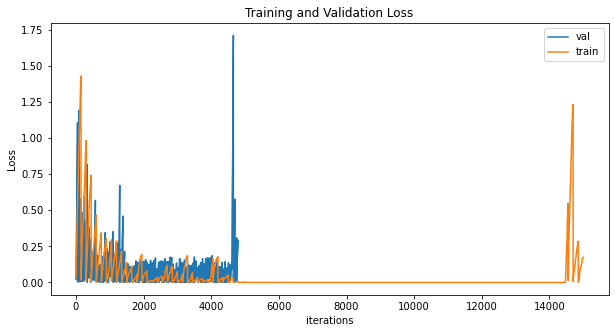

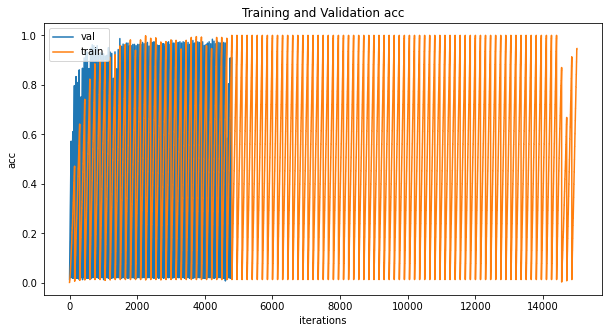

In [32]:
from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

#from data_loaders import Plain_Dataset, eval_data_dataloader
#from deep_emotion import Deep_Emotion
#from generate_data import Generate_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

val_losses_list = []
train_losses_list = []

val_acc_list = []
train_acc_list = []


def Train(epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)


        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len(train_dataset)
        train_acc = train_correct.double() / len(train_dataset)
        validation_loss =  validation_loss / len(val_dataset)
        val_acc = val_correct.double() / len(val_dataset)

        train_losses_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_losses_list.append(validation_loss)
        val_acc_list.append(val_acc)

        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

    torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")


epochs = 100
lr = 0.001
batchsize = 8

net = Deep_Emotion()
net.to(device)
from torchsummary import summary
summary(net, input_size=(1, 48, 48))
traincsv_file = 'data'+'/'+'val_ck.csv'
valcsv_file = 'data'+'/'+'finaltest_ck.csv'
train_img_dir = 'data'+'/'+'val_ck/'
val_img_dir = 'data'+'/'+'finaltest_ck/'

transformation = transforms.Compose([transforms.ToTensor()])
train_dataset = Plain_Dataset(csv_file = traincsv_file, img_dir = train_img_dir, datatype = 'val_ck',transform = transformation )
val_dataset = Plain_Dataset(csv_file = valcsv_file, img_dir = val_img_dir, datatype = 'finaltest_ck',transform = transformation )
train_loader = DataLoader(train_dataset,batch_size=batchsize, shuffle = True, num_workers=0)
val_loader = DataLoader(val_dataset,batch_size=batchsize, shuffle = True, num_workers=0)
criterion= nn.CrossEntropyLoss()
optmizer= optim.Adam(net.parameters(),lr= lr)

print(f"Train Data: {len(train_dataset)}")
print(f"Test Data: {len(val_dataset)}")

#Train(epochs, train_loader, val_loader, criterion, optmizer, device) 

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = net(data)
        loss = criterion(output, label)

        optmizer.zero_grad()
        loss.backward()
        optmizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        train_losses_list.append(epoch_loss.item())
        train_acc_list.append(epoch_accuracy.item())
        train_losses_list.append(epoch_loss.item())
        train_acc_list.append(epoch_accuracy.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = net(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)
            val_losses_list.append(epoch_val_loss.item())
            val_acc_list.append(epoch_val_accuracy.item())
        

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses_list,label="val")
plt.plot(train_losses_list,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation acc")
plt.plot(val_acc_list,label="val")
plt.plot(train_acc_list,label="train")
plt.xlabel("iterations")
plt.ylabel("acc")
plt.legend()
plt.show()



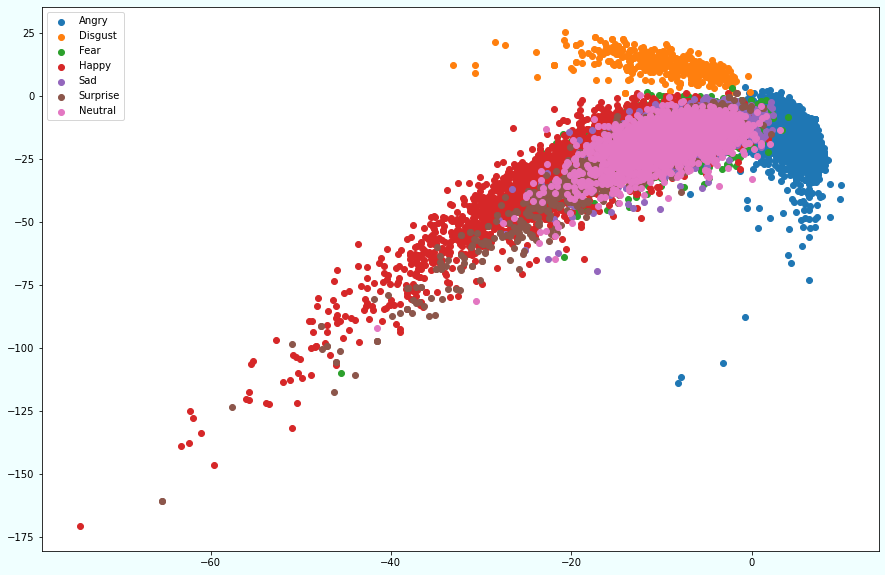

In [16]:
train_results =[]
labels =[]
classes=['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
net.eval()
with torch.no_grad():
    for img, label in train_loader:
        img,label = img.to(device),label.to(device)
        train_results.append(net(img).cpu().numpy())
        labels.append(label.cpu())
        
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

## visualization
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=classes[label])

plt.legend()
plt.show()

train with center loss 

In [ ]:
from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

#from data_loaders import Plain_Dataset, eval_data_dataloader
#from deep_emotion import Deep_Emotion
#from generate_data import Generate_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

val_losses_list = []
train_losses_list = []

val_acc_list = []
train_acc_list = []

epochs = 100
lr = 0.001
batchsize = 8

net = Deep_Emotion()
net.to(device)
from torchsummary import summary
summary(net, input_size=(1, 48, 48))
traincsv_file = 'data'+'/'+'train.csv'
valcsv_file = 'data'+'/'+'val_1.csv'
train_img_dir = 'data'+'/'+'train/'
val_img_dir = 'data'+'/'+'val_1/'

transformation = transforms.Compose([transforms.ToTensor()])
train_dataset = Plain_Dataset(csv_file = traincsv_file, img_dir = train_img_dir, datatype = 'train',transform = transformation )
val_dataset = Plain_Dataset(csv_file = valcsv_file, img_dir = val_img_dir, datatype = 'val_1',transform = transformation )
train_loader = DataLoader(train_dataset,batch_size=batchsize, shuffle = True, num_workers=0)
val_loader = DataLoader(val_dataset,batch_size=batchsize, shuffle = True, num_workers=0)
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optmizer= optim.Adam(net.parameters(),lr= lr)

print(f"Train Data: {len(train_dataset)}")
print(f"Test Data: {len(val_dataset)}")

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = net(data)
        loss = criterion(output, label)

        optmizer.zero_grad()
        loss.backward()
        optmizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        train_losses_list.append(epoch_loss.item())
        train_acc_list.append(epoch_accuracy.item())
        train_losses_list.append(epoch_loss.item())
        train_acc_list.append(epoch_accuracy.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = net(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)
            val_losses_list.append(epoch_val_loss.item())
            val_acc_list.append(epoch_val_accuracy.item())
        

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses_list,label="val")
plt.plot(train_losses_list,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation acc")
plt.plot(val_acc_list,label="val")
plt.plot(train_acc_list,label="train")
plt.xlabel("iterations")
plt.ylabel("acc")
plt.legend()
plt.show()



# test

In [7]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

In [22]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)




# traincsv_file = 'data'+'/'+'train.csv'
# valcsv_file = 'data'+'/'+'val_1.csv'
# train_img_dir = 'data'+'/'+'train/'
# val_img_dir = 'data'+'/'+'val_1/'

# transformation = transforms.Compose([transforms.ToTensor()])
# train_dataset = Plain_Dataset(csv_file = traincsv_file, img_dir = train_img_dir, datatype = 'train',transform = transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ]) )
# val_dataset = Plain_Dataset(csv_file = valcsv_file, img_dir = val_img_dir, datatype = 'val_1',transform = transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ]) )
# train_loader = DataLoader(train_dataset,batch_size=64, shuffle = True, num_workers=4)
# test_loader = DataLoader(val_dataset,batch_size=64, shuffle = True, num_workers=4)


In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [24]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.383913
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.837746

Test set: Average loss: 0.2381, Accuracy: 9309/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.416714
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.568639

Test set: Average loss: 0.1148, Accuracy: 9648/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.172193
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.265204

Test set: Average loss: 0.1044, Accuracy: 9671/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.188052
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.319820

Test set: Average loss: 0.2320, Accuracy: 9305/10000 (93%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.527591
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.256346

Test set: Average loss: 0.1910, Accuracy: 9366/10000 (94%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.671614
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.206810

Test set: Average loss: 0.0597, Accuracy: 9798/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.157210
Train Epoch: 7 [320

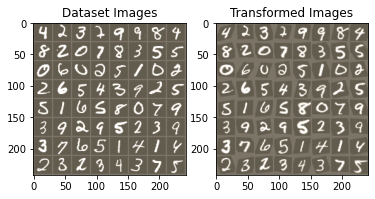

In [25]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()